# Example 1; the flow of deepSI

These examples will go over the following;

* Basic introduction and terminology
* Creating datasets and the .u and .y attributes
* Estimating Linear models
* Simulating datasets
* Evaluation, NRMS, and plotting (test - test_p)
* State-space encoder method
* Saving and loading models and systems

## 1. Basic introduction and terminology of deepSI. 

deepSI works with discrete-time samples where a system $G$ is actuated by inputs $u$ to obtain output measurement of $y$ as seen below

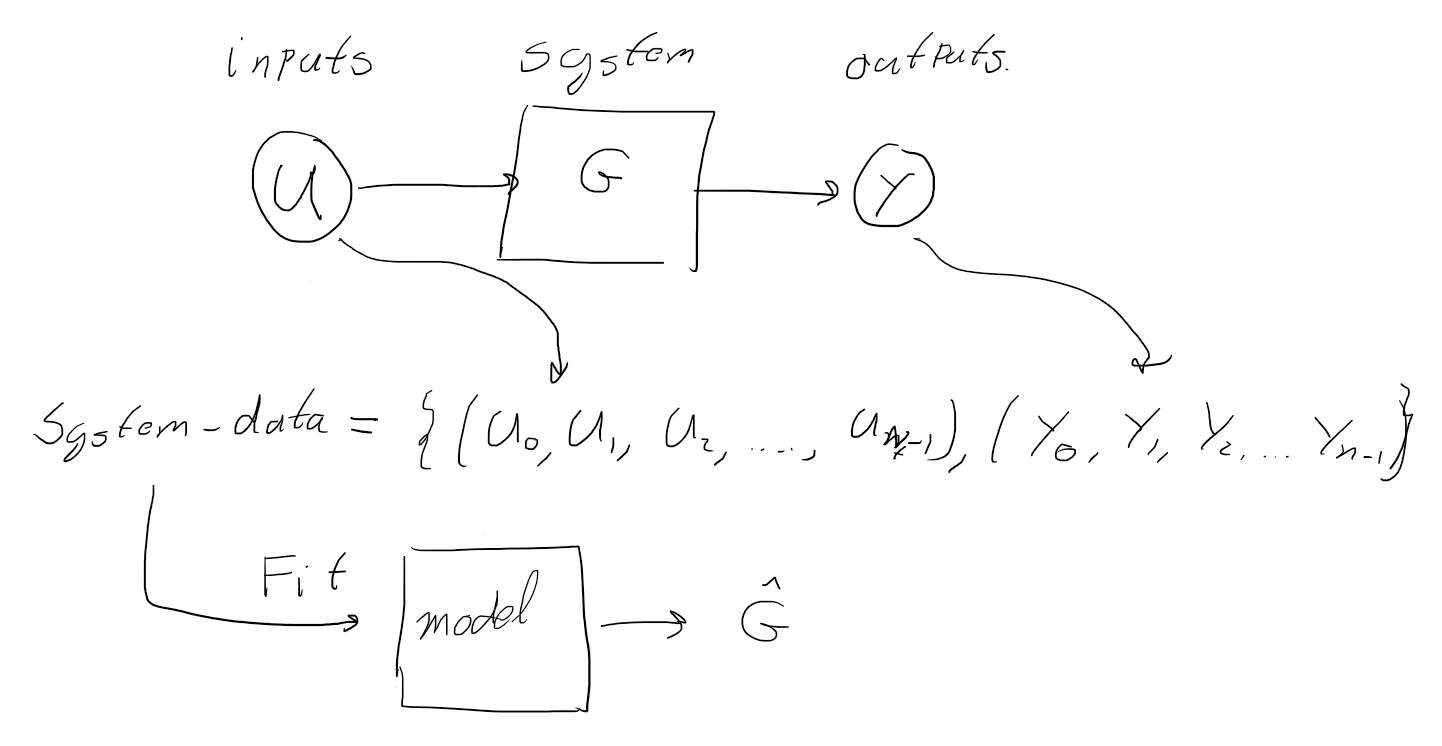

We collect both the input and output sequence into the system_data object which can be used to fit any kind of model to obtain an estimation of system $\hat{G}$. 

This model $\hat{G}$ then can be used as if they are system by running free run simulations. 

## 1. Create measurement data

$$
x_{k+1}^{(0)} = \frac{x_k^{(0)}}{1.2 + \left(x_k^{(1)}\right)^2} + 0.4 x_k^{(1)}
$$
$$
x_{k+1}^{(1)} = \frac{x_k^{(1)}}{1.2 + \left(x_k^{(0)}\right)^2} + 0.4 x_k^{(0)} + u_k \left (1 + 0.1\left (x_k^{(0)} \right )^2 \right )$$
$$y_k = 0.1 x_k^{(1)} x_k^{(0)} + x_k^{(0)}
$$ 

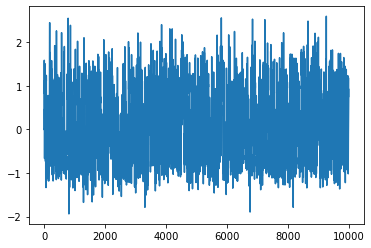

u [ 0.17576228  1.8552512   1.63218773 -0.69583152 -0.98810554  0.80087235
  1.13171795 -0.27456903 -0.32952396 -1.0273437 ]
y [0.         0.         0.08437799 1.08469462 1.58626153 0.98272223
 0.82358597 0.92296195 1.12116886 0.91197156]


In [1]:
import numpy as np
N = 10_000
ulist = np.random.normal(size=N) #input sequence
ylist = []
x = [0,0]
for uk in ulist:
    yk = x[1]*x[0]*0.1 + x[0]
    ylist.append(yk)
    
    x = x[0]/(1.2+x[1]**2) + x[1]*0.4, x[1]/(1.2+x[0]**2)+x[0]*0.4+uk*(1+x[0]**2/10)

    
ylist = np.array(ylist)
#show results
from  matplotlib import pyplot as plt
plt.plot(ylist)
plt.show()

print('u',ulist[:10])
print('y',ylist[:10])

Put the system data in the `System_data` format to be processed by deepSI and split data set into train and test

System_data of length: 10000 nu=None ny=None normed=False dt=None


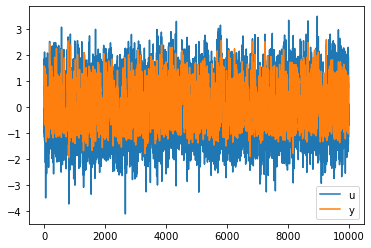

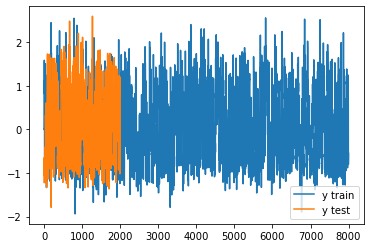

In [2]:
import deepSI
from deepSI import System_data
system_data = System_data(u=ulist,y=ylist)
print(system_data) #contains both the input and the output
plt.plot(system_data.u) #system_data.y contains the output array of length N
plt.plot(system_data.y) #system_data.u contains the input  array of length N
plt.legend(['u','y'])
plt.show()

train, test = system_data[:8000], system_data[8000:] #slice the datatset in two (or use system_data.train_test_split(split_fraction=0.2))
plt.plot(train.y,label='y train')
plt.plot(test.y,label='y test')
plt.legend()
plt.show()

## 2. Estimate an ARX and linear state-space model



In [3]:
fit_sys_SS = deepSI.fit_systems.SS_linear(nx=3) #SS_f = 8
fit_sys_IO = deepSI.fit_systems.Sklearn_io_linear(na=2,nb=2)

fit_sys_SS.fit(train, SS_f = 8)
print(f'SS \tA={fit_sys_SS.A} \n \t B={fit_sys_SS.B}\n\t C={fit_sys_SS.C}') #parameters

fit_sys_IO.fit(train)
print(f'ARX paramters: [A,B] = {fit_sys_IO.reg.coef_} offset={fit_sys_IO.reg.intercept_}')  #parameters


SS 	A=[[ 0.90058804  0.10396027  0.00100532]
 [-0.35921519  0.15960689 -0.02107423]
 [-0.01446256  0.62770162  0.82071406]] 
 	 B=[[-0.39282058]
 [-0.92750828]
 [ 0.0562857 ]]
	 C=[[-0.84103975  0.3547988   0.00149134]]
ARX paramters: [A,B] = [ 0.37320253  0.00191922 -0.15654175  1.03017991] offset=-0.00011328286318503216


## 3. Running simulations and evaulating fitted models (systems)

RMS simulation SS linear 0.38
RMS simulation IO linear 0.38
NRMS simulation SS linear 46.90%
NRMS simulation IO linear 46.85%


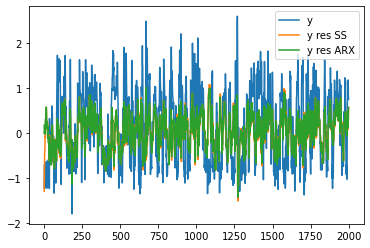

In [4]:
# uses a free run simulation from the appropriate initial state 
# (see docs for details: https://deepsi.readthedocs.io/en/latest/systems.html#deepSI.systems.System.apply_experiment)
test_sim_SS = fit_sys_SS.apply_experiment(test)
test_sim_IO = fit_sys_IO.apply_experiment(test) 

#calculate errors errors
print(f'RMS simulation SS linear {test_sim_SS.RMS(test):.2}') #equivilent to np.mean((test_sim_SS.y - test.y)**2)**0.5
print(f'RMS simulation IO linear {test_sim_IO.RMS(test):.2}') #equivilent to np.mean((test_sim_IO.y[2:] - test.y[2:])**2)**0.5

print(f'NRMS simulation SS linear {test_sim_SS.NRMS(test):.2%}') #equivilent to np.mean((test_sim_SS.y - test.y)**2)**0.5/np.std(test.y)
print(f'NRMS simulation IO linear {test_sim_IO.NRMS(test):.2%}') #equivilent to np.mean((test_sim_IO.y[2:] - test.y[2:])**2)**0.5/np.std(test.y)

plt.plot(test.y)
plt.plot(test.y - test_sim_SS.y)
plt.plot(test.y - test_sim_IO.y)
plt.legend(['y','y res SS','y res ARX'])
plt.show()

## 4. SS encoder approach

The SS encoder (https://arxiv.org/abs/2012.07697) is a versatile method for many non-linear estimation problems.

**Caution!** Optimization might take very long, it's quite common to wait up to 12 hours. one might use a KeyboardInterrupt (Ctrl-C on command lines) to cut the optimization short which will not crash the program.

**Caution** Using a if `__name__=='__main__'` is essential for good opperation in scripts. (XXX link)

In [5]:
fit_sys_ss_enc = deepSI.fit_systems.SS_encoder(nx=6, na=3, nb=3) #state dimention = 6, past outputs = 3, past inputs = 3.
train_enc, val_enc = train.train_test_split(split_fraction=0.25)

#Start fitting
fit_sys_ss_enc.fit(train_enc, sim_val=val_enc, epochs=100, batch_size=256, loss_kwargs={'nf':50}) #nf is T in paper

Size of the training array =  4.8 MB
N_training_samples = 5948, batch_size = 256, N_batch_updates_per_epoch = 23
Initial Validation NRMS= 1.0448238026499206


  0%|          | 0/100 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### NRMS = 0.4369949481516129
Epoch    1, sqrt loss  0.7536, Val NRMS  0.437, Time Loss: 72.9%, data: 0.6%, val: 26.4%, 14.1 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.30618639128255554
Epoch    2, sqrt loss  0.3368, Val NRMS 0.3062, Time Loss: 72.5%, data: 0.3%, val: 27.1%, 14.5 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.26319866629165733
Epoch    3, sqrt loss  0.2597, Val NRMS 0.2632, Time Loss: 72.5%, data: 0.4%, val: 27.1%, 14.5 batches/sec
Epoch    4, sqrt loss  0.2391, Val NRMS  0.265, Time Loss: 72.5%, data: 0.3%, val: 27.1%, 14.6 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.24763763636238753
Epoch    5, sqrt loss  0.2316, Val NRMS 0.2476, Time Loss: 72.3%, data: 0.3%, val: 27.3%, 14.8 batches/sec
Epoch    6, sqrt loss  0.2239, Val NRMS 0.2717, Time Loss: 72.4%, data: 0.3%, val: 27.3%, 14.7 batches/sec
########## New 

########## New lowest validation loss achieved ########### NRMS = 0.08051967986325086
Epoch   54, sqrt loss 0.06516, Val NRMS 0.08052, Time Loss: 72.4%, data: 0.3%, val: 27.3%, 14.7 batches/sec
Epoch   55, sqrt loss 0.06435, Val NRMS 0.08304, Time Loss: 72.4%, data: 0.3%, val: 27.3%, 14.7 batches/sec
Epoch   56, sqrt loss 0.06362, Val NRMS 0.0827, Time Loss: 72.4%, data: 0.3%, val: 27.3%, 14.7 batches/sec
Epoch   57, sqrt loss 0.06304, Val NRMS 0.08266, Time Loss: 72.4%, data: 0.3%, val: 27.3%, 14.7 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.07812196488130314
Epoch   58, sqrt loss 0.06267, Val NRMS 0.07812, Time Loss: 72.4%, data: 0.3%, val: 27.3%, 14.7 batches/sec
Epoch   59, sqrt loss 0.06173, Val NRMS 0.07834, Time Loss: 72.3%, data: 0.3%, val: 27.4%, 14.7 batches/sec
########## New lowest validation loss achieved ########### NRMS = 0.07781485213493529
Epoch   60, sqrt loss 0.06182, Val NRMS 0.07781, Time Loss: 72.4%, data: 0.3%, val: 27.3%, 14.7

reading a row of the optimization results

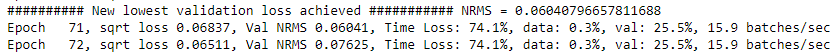

Here one can see a row, it states:

 * Epoch: current epoch
 * sqrt loss: the average of sqrt(loss) over the last epoch
 * Val NRMS: the NRMS simulation on the dataset given by `sim_val=val_enc`
 * Time Loss: X%, data: Y%, val Z% the timetable of how much time is spent on each task.
    * Loss: propagating computation forward and backwards
    * data: creating batches
    * val: validation process after each epoch. 
 * X batches/sec, the number of updates per second that are made. Generally in the range of 5 to 60 batches/sec

The validation loop is executed after each epoch (by default) and will be printed with the #############  ########## to screen if a new lowest validation is obtained. 

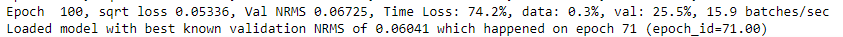

After the optimization is done or cut short the parameter values are loaded for which the lowest validation loss was obtained. This effectively is a version of early stopping using a validation set. 

If you want to view the last you can use

```python
fit_sys_ss_enc.checkpoint_load_system('_last')
```
and to load the one with the lowest validation loss use

```python
fit_sys_ss_enc.checkpoint_load_system('_best')
```

In [6]:
print(fit_sys_ss_enc.fn) #state network x_t+1 = f([x,u])
print(fit_sys_ss_enc.hn) #state network y_t = h(x_t)
print(fit_sys_ss_enc.encoder) #state network x_t = psi([upast, ypast])

simple_res_net(
  (net_lin): Linear(in_features=7, out_features=6, bias=True)
  (net_non_lin): feed_forward_nn(
    (net): Sequential(
      (0): Linear(in_features=7, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=6, bias=True)
    )
  )
)
simple_res_net(
  (net_lin): Linear(in_features=6, out_features=1, bias=True)
  (net_non_lin): feed_forward_nn(
    (net): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)
simple_res_net(
  (net_lin): Linear(in_features=6, out_features=6, bias=True)
  (net_non_lin): feed_forward_nn(
    (net): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, b

RMS simulation SS linear  0.38
RMS simulation IO linear  0.38
RMS simulation SS encoder 0.057
NRMS simulation SS linear  46.90%
NRMS simulation IO linear  46.85%
NRMS simulation SS encoder 7.14%


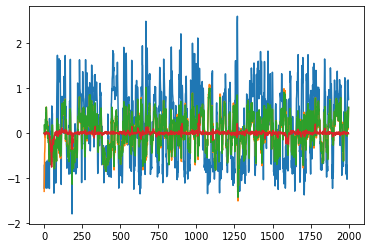

In [7]:
test_sim_enc = fit_sys_ss_enc.apply_experiment(test)

print(f'RMS simulation SS linear  {test_sim_SS.RMS(test):.2}') #equivilent to np.mean((test_sim_SS.y - test.y)**2)**0.5
print(f'RMS simulation IO linear  {test_sim_IO.RMS(test):.2}') #equivilent to np.mean((test_sim_IO.y[2:] - test.y[2:])**2)**0.5
print(f'RMS simulation SS encoder {test_sim_enc.RMS(test):.2}') #equivilent to np.mean((test_sim_enc.y[2:] - test.y[2:])**2)**0.5

print(f'NRMS simulation SS linear  {test_sim_SS.NRMS(test):.2%}') #equivilent to np.mean((test_sim_SS.y - test.y)**2)**0.5/np.std(test.y)
print(f'NRMS simulation IO linear  {test_sim_IO.NRMS(test):.2%}') #equivilent to np.mean((test_sim_IO.y[2:] - test.y[2:])**2)**0.5/np.std(test.y)
print(f'NRMS simulation SS encoder {test_sim_enc.NRMS(test):.2%}') #equivilent to np.mean((test_sim_enc.y[2:] - test.y[2:])**2)**0.5/np.std(test.y)

plt.plot(test.y)
plt.plot(test.y - test_sim_SS.y)
plt.plot(test.y - test_sim_IO.y)
plt.plot(test.y - test_sim_enc.y)
plt.show()

## 4.2 Futher Analysis


### 4.2.1 Loss/training curves

One can obtain the training curves as follows; 

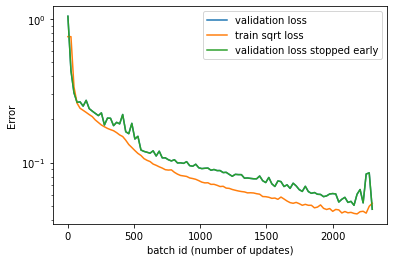

In [8]:

fit_sys_ss_enc.checkpoint_load_system('_last')

plt.semilogy(fit_sys_ss_enc.batch_id,fit_sys_ss_enc.Loss_val,label='validation loss') #or use fit_sys_ss_enc.epoch_id for epochs
plt.semilogy(fit_sys_ss_enc.batch_id,fit_sys_ss_enc.Loss_train**0.5,label='train sqrt loss')
plt.xlabel('batch id (number of updates)')
plt.ylabel('Error')

fit_sys_ss_enc.checkpoint_load_system('_best')
plt.semilogy(fit_sys_ss_enc.batch_id,fit_sys_ss_enc.Loss_val,label='validation loss stopped early')
plt.legend()
plt.show()

### 4.2.2 n-step errors

One of the best ways to analyise and develop models is in my opinion to analyse the n-step-error.

n-step-error is very simple; it is the (normalized) expected error after taking $n$ steps forward in time after state initialization. (see: https://arxiv.org/abs/2012.07697 for details or docs for details)

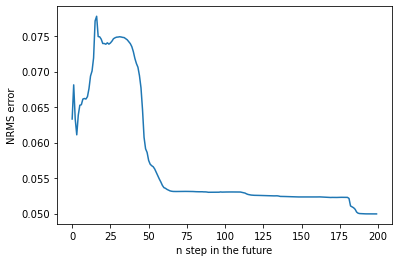

In [9]:
nsteperror = fit_sys_ss_enc.n_step_error(test,nf=200) #return in NRMS units of fit_sys_ss_enc.norm
plt.plot(nsteperror)
plt.xlabel('n step in the future')
plt.ylabel('NRMS error')
plt.show()

### 4.2.3 view state variables

One might want insight into what $x_t$ is so one can use `save_state=True` on `apply_experiment` so also save the state on `system_data.x` as follows;

(2000, 6)


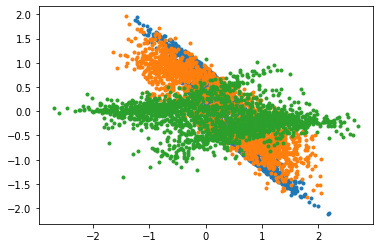

In [10]:
test_sim = fit_sys_ss_enc.apply_experiment(test,save_state=True)
X = test_sim.x #the System_data now has a .x attribute with shape (Ntime, nx)
print(X.shape)
plt.plot(X[:,0],X[:,1],'.')
plt.plot(X[:,2],X[:,3],'.')
plt.plot(X[:,4],X[:,5],'.')
plt.show()

## 4.3 Saving and loading systems results

Saving and loading models or systems are done with the pickle module. Any object saved with the pickle module saves only the object and not the associated code (class), hence this needs to be available when loading by

* Having the class defined in the file itself. (may require a `if __name__=='__main__'` to work correctly)
* or the class needs to available for import. 

In [11]:
### save to file ###

# fit_sys_IO.save_system('IO-sys')
# fit_sys_SS.save_system('SS-sys')
# fit_sys_ss_enc.save_system('enc-sys')

### load from file ###

# fit_sys_IO = deepSI.load_system('IO-sys')
# fit_sys_SS = deepSI.load_system('IO-sys')
# fit_sys_ss_enc = deepSI.load_system('enc-sys')

## 4.4 Recovery of system after crash

Furthermore, after a crash, you might want to recover the estimated system. 

It is quite a hack but the following process works

1. go to the check_point directory given by 

In [12]:
deepSI.datasets.get_work_dirs()['checkpoints']

'C:\\Users\\gerben\\AppData\\Local\\deepSI/checkpoints/'

2. Note down the id of the last system (or the one you want to recover) saved (here it is 'iTOcsA')

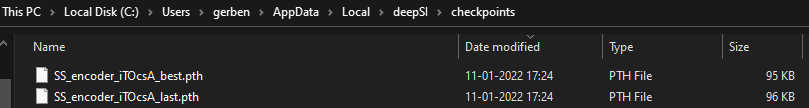

3. Recreate the system, set the unique code variable and load the last checkpoint as;

4. save the system normally.

In [13]:
fit_sys_ss_enc = deepSI.fit_systems.SS_encoder(nx=6, na=3, nb=3)
fit_sys_ss_enc.unique_code = 'iTOcsA'
fit_sys_ss_enc.checkpoint_load_system('_best')

# fit_sys_ss_enc.save_system('') #save it normally